Data analysis (+EDA)

In [ ]:
#shapes, plots,

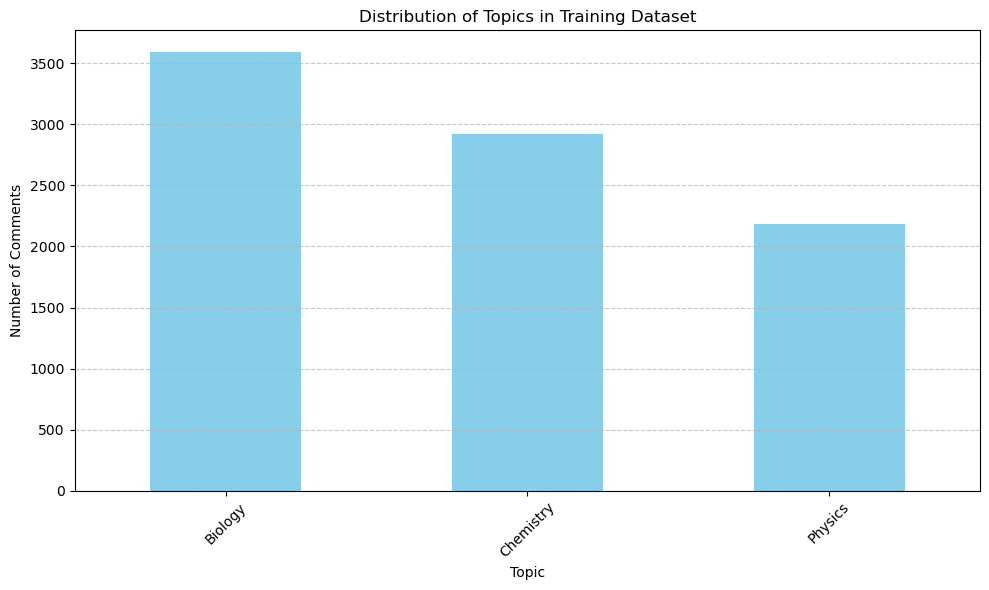

Topic
Biology      3591
Chemistry    2920
Physics      2184
Name: count, dtype: int64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (update the file path if needed)
train_data = pd.read_csv('dataset/train.csv')

# Analyze the distribution of topics in the training dataset
topic_counts = train_data['Topic'].value_counts()

# Plot the distribution of topics
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Topics in Training Dataset')
plt.xlabel('Topic')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the topic counts for reference
print(topic_counts)


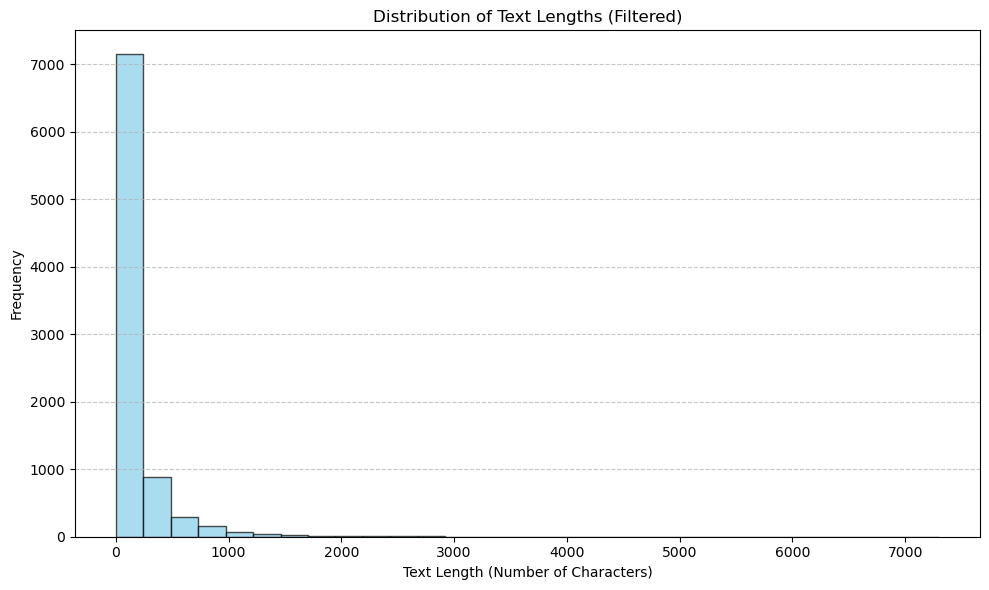

count    8695.000000
mean      169.286832
std       294.992807
min         1.000000
25%        36.000000
50%        78.000000
75%       174.000000
max      7298.000000
Name: text_length, dtype: float64


In [13]:
# Remove comments with text length > 1000
filtered_data = train_data[train_data['text_length'] <= 8000]

# Plot the distribution again
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['text_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Text Lengths (Filtered)')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display new statistics
print(filtered_data['text_length'].describe())


[nltk_data] Downloading package stopwords to C:\Users\Ricardo
[nltk_data]     Milos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Ricardo Milos\AppData\Local\Temp\ipykernel_24072\1172208940.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cleaned_tokens'] = filtered_data['Comment'].apply(tokenize_and_clean)


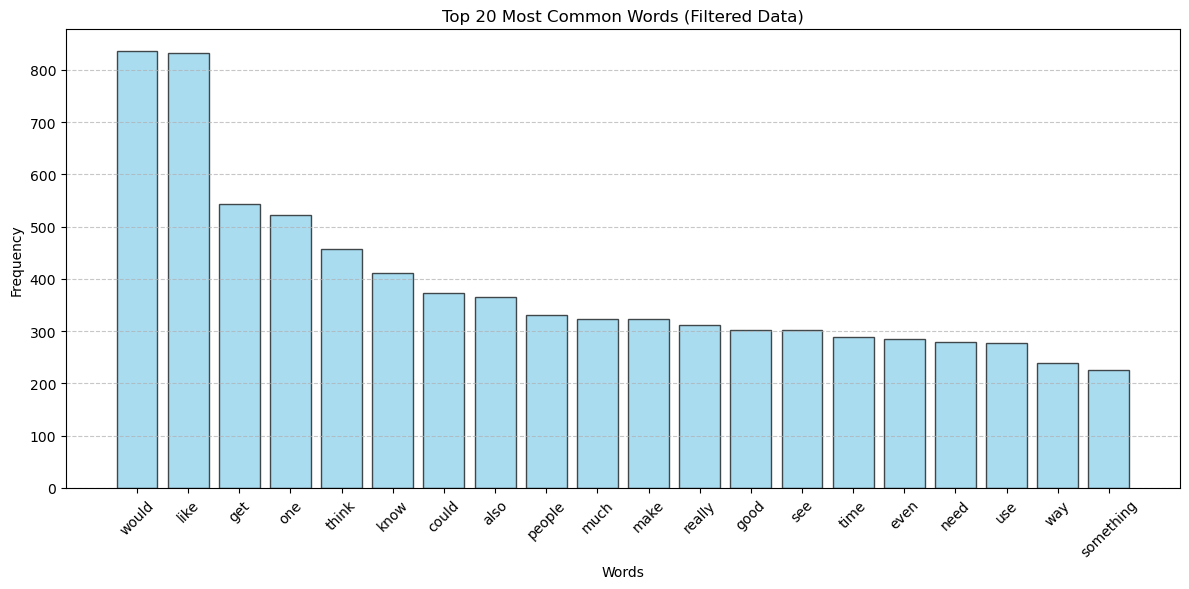

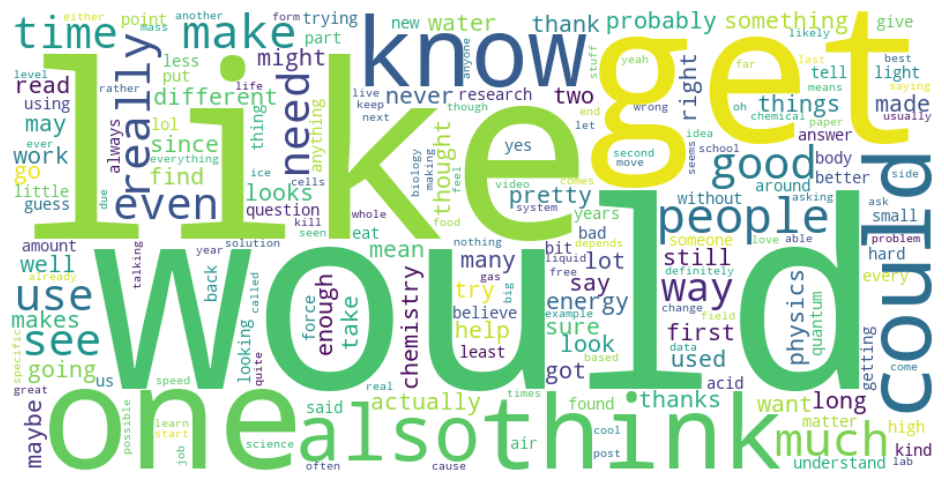

In [12]:
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Tokenize and clean the text
def tokenize_and_clean(text):
    tokens = text.lower().split()  # Convert to lowercase and split into words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove non-alphabetic and stop words
    return tokens

# Apply tokenization to the filtered data
filtered_data['cleaned_tokens'] = filtered_data['Comment'].apply(tokenize_and_clean)

# Flatten the list of tokens and count word frequencies
all_words = [word for tokens in filtered_data['cleaned_tokens'] for word in tokens]
word_counts = Counter(all_words)

# Get the 20 most common words
most_common_words = word_counts.most_common(20)

# Plot the most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Top 20 Most Common Words (Filtered Data)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [6]:
%pip install wordcloud


                                              0.0/299.9 kB ? eta -:--:--
     ------------------                     143.4/299.9 kB 4.3 MB/s eta 0:00:01
     -------------------------------------- 299.9/299.9 kB 6.3 MB/s eta 0:00:00


In [15]:
#feature engineering.

Model 1 : K-medoids


Unique Cluster Labels: {0, 1, 2}
Silhouette Score: 0.3414665742412127


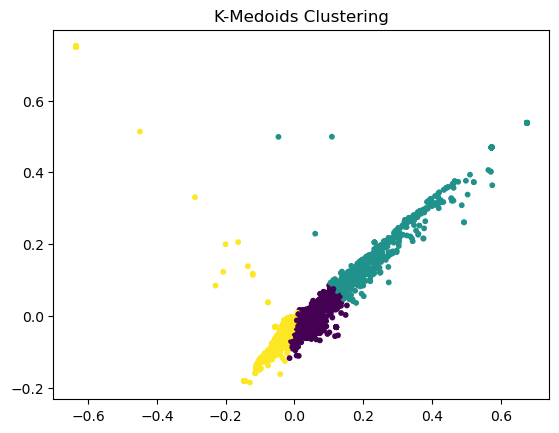

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer


# Load the dataset
df = pd.read_csv('dataset/train.csv')

# Preprocessing: Extract the 'Comment' column
comments = df['Comment']

# Step 1: Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Adjust max_features
X = vectorizer.fit_transform(comments).toarray()

# Step 2: Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Reduce dimensionality (optional but recommended)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

# Step 4: Apply K-Medoids clustering
kmedoids = KMedoids(n_clusters=3, random_state=42)
kmedoids.fit(X_reduced)

# Check unique cluster labels
print(f'Unique Cluster Labels: {set(kmedoids.labels_)}')

# Add the cluster labels to the DataFrame
df['Cluster'] = kmedoids.labels_

# Step 5: Evaluate the clustering using Silhouette Score
if len(set(kmedoids.labels_)) > 1:  # Ensure there are at least 2 clusters
    sil_score = silhouette_score(X_reduced, kmedoids.labels_)
    print(f'Silhouette Score: {sil_score}')
else:
    print("Silhouette Score cannot be calculated with only one cluster.")

# Step 6: Visualize the clustering
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmedoids.labels_, cmap='viridis', s=10)
plt.title('K-Medoids Clustering')
plt.show()

# Save the results to a CSV file
df.to_csv('clustered_dataset.csv', index=False)


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

# Load the training dataset
train_file_path = 'dataset/train.csv'
data = pd.read_csv(train_file_path)

# Preprocessing function
def preprocess_text(text):
    """Basic text preprocessing: Lowercasing and removing punctuation."""
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing to the 'Comment' column
data['processed_comment'] = data['Comment'].apply(preprocess_text)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data['processed_comment'])

# Define an LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # 3 topics for Physics, Biology, Chemistry
lda.fit(X)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_components': [3, 5, 7, 10],  # Test with different numbers of topics
    'learning_decay': [0.1, 0.25, 0.5, 0.9]  # Learning decay hyperparameter
}

lda_grid = GridSearchCV(LatentDirichletAllocation(random_state=42), param_grid, cv=3, n_jobs=-1)
lda_grid.fit(X)

# Best model
best_lda_model = lda_grid.best_estimator_
print("Best LDA model parameters:", lda_grid.best_params_)

# Silhouette Score using KMeans clustering on the LDA topic distributions
lda_topic_distributions = best_lda_model.transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(lda_topic_distributions)

sil_score = silhouette_score(lda_topic_distributions, labels)
print(f"Silhouette Score: {sil_score}")

# Save LDA topic distributions for later use
data['lda_topics'] = np.argmax(lda_topic_distributions, axis=1)
print(data[['Comment', 'lda_topics']].head())


Topic 0:
people just dont youre time thanks right know work im physics lot thats think theres force yes need new cells
Topic 1:
just dont im good like thats know think sure chemistry water make want thank probably did use acid try really
Topic 2:
like energy just different does time think matter looks alan way light makes co2 water make thought air really doesnt
Best LDA model parameters: {'learning_decay': 0.1, 'n_components': 3}


D:\Program Files\anaconda 3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5769851830058761
                                             Comment  lda_topics
0  A few things. You might have negative- frequen...           2
1  Is it so hard to believe that there exist part...           2
2                                     There are bees           2
3  I'm a medication technician. And that's alot o...           1
4                     Cesium is such a pretty metal.           1


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.cluster import KMeans
from scipy.stats import mode
import numpy as np

# Load the training and test datasets
train_file_path = 'dataset/train.csv'
test_file_path = 'dataset/test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Preprocessing function
def preprocess_text(text):
    """Basic text preprocessing: Lowercasing and removing punctuation."""
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing to the 'Comment' column
train_data['processed_comment'] = train_data['Comment'].apply(preprocess_text)
test_data['processed_comment'] = test_data['Comment'].apply(preprocess_text)

# Vectorize the text data using CountVectorizer (fit on training data, transform both train and test)
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_data['processed_comment'])
X_test = vectorizer.transform(test_data['processed_comment'])

# Define and fit the initial LDA model
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # Start with 3 topics
lda.fit(X_train)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 30
print("Topics for initial LDA model:")
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_components': [3],  # Focus on n_components >= 3
    'learning_decay': [0.001, 0.005, 0.01, 0.05]  # Learning decay hyperparameter
}

lda_grid = GridSearchCV(LatentDirichletAllocation(random_state=42), param_grid, cv=3, n_jobs=-1)
lda_grid.fit(X_train)

# Best model from GridSearchCV
best_lda_model = lda_grid.best_estimator_
print("Best LDA model parameters:", lda_grid.best_params_)

# Transform the training and test datasets using the best LDA model
train_topic_distributions = best_lda_model.transform(X_train)
test_topic_distributions = best_lda_model.transform(X_test)

# Silhouette Score using KMeans clustering on the training topic distributions
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(train_topic_distributions)

sil_score = silhouette_score(train_topic_distributions, labels)
print(f"Silhouette Score (Train): {sil_score}")

# Silhouette Score for the test dataset
kmeans_test = KMeans(n_clusters=3, random_state=42)
test_labels = kmeans_test.fit_predict(test_topic_distributions)

sil_score_test = silhouette_score(test_topic_distributions, test_labels)
print(f"Silhouette Score (Test): {sil_score_test}")

# Assign topic predictions to both training and test data
train_data['lda_topics'] = np.argmax(train_topic_distributions, axis=1)
test_data['lda_topics'] = np.argmax(test_topic_distributions, axis=1)

# Map string labels in 'Topic' to numeric labels
label_mapping = {'Biology': 0, 'Chemistry': 1, 'Physics': 2}
train_data['Topic_numeric'] = train_data['Topic'].map(label_mapping)
test_data['Topic_numeric'] = test_data['Topic'].map(label_mapping)

# Confusion matrix for training data
train_confusion = confusion_matrix(train_data['Topic_numeric'], train_data['lda_topics'])

# Map LDA topics to ground truth topics based on the confusion matrix
topic_mapping = {}
for lda_topic in range(train_confusion.shape[1]):
    # Find the most common ground truth topic for each LDA topic
    most_common_topic = np.argmax(train_confusion[:, lda_topic])
    topic_mapping[lda_topic] = most_common_topic

# Reassign the LDA topics based on the mapping for both train and test
train_data['mapped_lda_topics'] = train_data['lda_topics'].map(topic_mapping)
test_data['mapped_lda_topics'] = test_data['lda_topics'].map(topic_mapping)

# Recalculate ARI with the mapped topics
ari_train_mapped = adjusted_rand_score(train_data['Topic_numeric'], train_data['mapped_lda_topics'])
ari_test_mapped = adjusted_rand_score(test_data['Topic_numeric'], test_data['mapped_lda_topics'])

print(f"Adjusted Rand Index (Train, Mapped): {ari_train_mapped}")
print(f"Adjusted Rand Index (Test, Mapped): {ari_test_mapped}")


print("Training data with LDA topics:")
print(train_data[['Comment', 'lda_topics']].head())

print("Test data with LDA topics:")
print(test_data[['Comment', 'lda_topics']].head())

# Save the outputs
train_data.to_csv('train_with_lda_topics.csv', index=False)
test_data.to_csv('test_with_lda_topics.csv', index=False)


Topics for initial LDA model:
Topic 0:
thats just im thank time like does light think force matter know mass doesnt quantum say energy youre mean way sense dont sure thing really make isnt theory makes question
Topic 1:
water like just energy acid make dont different think use way body cells air co2 used eat im does carbon need food gas time know solution bullet thats yes concentration
Topic 2:
just like dont im good know people think really chemistry thanks want youre lot work time need things probably going physics did make help way ive years thats use alan
Best LDA model parameters: {'learning_decay': 0.001, 'n_components': 3}


D:\Program Files\anaconda 3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score (Train): 0.623050257911497
Silhouette Score (Test): 0.5233280381862662
Adjusted Rand Index (Train, Mapped): 0.03633979163712715
Adjusted Rand Index (Test, Mapped): 0.07995405927332395
Training data with LDA topics:
                                             Comment  lda_topics
0  A few things. You might have negative- frequen...           0
1  Is it so hard to believe that there exist part...           0
2                                     There are bees           2
3  I'm a medication technician. And that's alot o...           2
4                     Cesium is such a pretty metal.           1
Test data with LDA topics:
                                             Comment  lda_topics
0  Personally I have no idea what my IQ is. I’ve ...           2
1  I'm skeptical. A heavier lid would be needed t...           0
2  I think I have 100 cm of books on the subject....           0
3  Is chemistry hard in uni. Ive read somewhere t...           2
4  In addition to the othe

D:\Program Files\anaconda 3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
print("Training data with LDA topics:")
print(train_data[['Comment', 'lda_topics']].head(20))

print("Test data with LDA topics:")
print(test_data[['Comment', 'lda_topics']].head(20))

Training data with LDA topics:
                                              Comment  lda_topics
0   A few things. You might have negative- frequen...           0
1   Is it so hard to believe that there exist part...           0
2                                      There are bees           2
3   I'm a medication technician. And that's alot o...           2
4                      Cesium is such a pretty metal.           1
5        I meant that the question itself is unclear.           0
6           Shove it up your ass and see what happens           0
7   ??? I mean it has some butter, but besides tha...           1
8              https://t.me/joinchat/3gElLHLuMCxhNGI0           0
9   Well, that’s just the thing. You can’t really ...           0
10   Is H2S what produced when the egg protein is ...           1
11  And the mRNA would have to have a specific pro...           1
12  He's probably just really torn up about the Dr...           2
13       Has this helped you with the 4.8% va

[nltk_data] Downloading package stopwords to C:\Users\Ricardo
[nltk_data]     Milos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ricardo
[nltk_data]     Milos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Silhouette Score: -0.3713710918334955


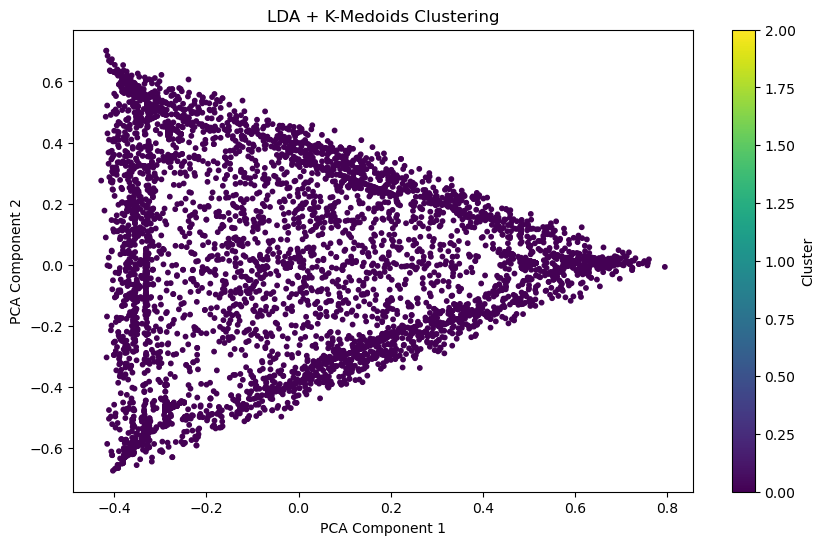

Topic 0: like, look, thanks, sure, time, ha, use, really, try, read
Topic 1: thank, wa, think, doe, probably, water, different, question, acid, light
Topic 2: know, good, need, work, lot, way, wa, make, pretty, mean


In [35]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv('dataset/train.csv')

# Preprocessing: Text cleaning and lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['Processed_Comment'] = df['Comment'].apply(preprocess)

# Step 1: Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_tfidf = vectorizer.fit_transform(df['Processed_Comment']).toarray()

# Step 2: Apply Latent Dirichlet Allocation (LDA) for dimensionality reduction
n_topics = 3  # Number of topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
X_lda = lda_model.fit_transform(X_tfidf)

# Step 3: Normalize the LDA output
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_lda)

# Step 4: Optionally reduce dimensionality for visualization (using PCA)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

# Step 5: Apply K-Medoids clustering on the LDA output
kmedoids = KMedoids(n_clusters=n_topics, random_state=42)
kmedoids.fit(X_scaled)  # Use X_scaled for clustering based on topic proportions

# Add the cluster labels to the DataFrame
df['Cluster'] = kmedoids.labels_

# Step 6: Evaluate clustering using Silhouette Score
if len(set(kmedoids.labels_)) > 1:  # Ensure there are at least 2 clusters
    sil_score = silhouette_score(X_scaled, kmedoids.labels_)
    print(f'Silhouette Score: {sil_score}')
else:
    print("Silhouette Score cannot be calculated with only one cluster.")

# Step 7: Visualize the clustering (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmedoids.labels_, cmap='viridis', s=10)
plt.title('LDA + K-Medoids Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 8: Inspect top words for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Save the results to a CSV file
df.to_csv('lda_clustered_dataset.csv', index=False)


In [5]:
print(f'Unique Cluster Labels: {set(kmedoids.labels_)}')


Unique Cluster Labels: {0, 1, 2}


Model 2 : LDA

n_components: 3, learning_decay: 0.05, learning_offset: 1, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.05, learning_offset: 10, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.05, learning_offset: 200, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.05, learning_offset: 2000, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.01, learning_offset: 1, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.01, learning_offset: 10, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.01, learning_offset: 200, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.01, learning_offset: 2000, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.2, learning_offset: 1, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.2, learning_offset: 10, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.2, learning_offset: 200, Perplexity: 2559.4151
n_components: 3, learning_decay: 0.2, learning_offset: 2000, Perplexity: 2559.4151
Best Parameter

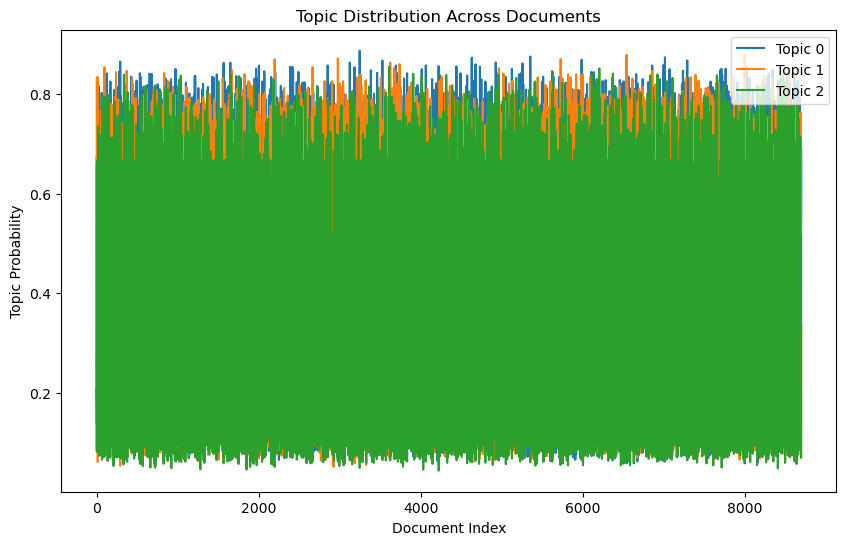

Topic 0: thanks, time, water, sure, question, make, good, biology, need, light
Topic 1: chemistry, read, mean, right, thought, yeah, people, probably, year, eat
Topic 2: removed, look, deleted, http, lol, think, thing, com, mushroom, video


In [30]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# --- 1. Load Dataset and Domain-Specific Preprocessing ---

def preprocess_text_domain_specific(text):
    lemmatizer = WordNetLemmatizer()
    custom_stopwords = set(stopwords.words('english')).union({
        "like", "just", "know", "thank", "yes", "want", "really", "don", "doesn", "didn"
    })
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())  # Remove non-alphabet characters
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in custom_stopwords and len(word) > 2]
    return ' '.join(tokens)

# Load the dataset
train_data = pd.read_csv('dataset/train.csv')
train_data['Cleaned_Comment'] = train_data['Comment'].apply(preprocess_text_domain_specific)

corpus = train_data['Cleaned_Comment'].tolist()

# --- 2. Feature Extraction with Weighted Domain-Specific Terms ---

# Define domain-specific terms for boosting their weights
domain_terms = {"reactor", "neutron", "gene", "genome", "superconductor", "magnetic", "chemistry", "physics", "biology"}

# TF-IDF Vectorizer with ngrams
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=2000,  # Larger vocabulary size
    min_df=2,           # Remove very rare terms
    max_df=0.85,        # Remove overly common terms
    ngram_range=(1, 2)  # Unigrams and bigrams
)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# Boost weights for domain-specific terms
feature_names = tfidf_vectorizer.get_feature_names_out()
for term in domain_terms:
    if term in tfidf_vectorizer.vocabulary_:
        idx = tfidf_vectorizer.vocabulary_[term]
        X_tfidf[:, idx] *= 1.5  # Boost weight for domain-specific terms

# --- 3. Refined LDA Parameters with Grid Search ---

# Define LDA model
lda = LatentDirichletAllocation(random_state=42)

# --- Manual Grid Search for LDA ---
best_score = float('inf')  # Initialize with a large value
best_model = None
best_params = None

# Iterate over the parameter grid
param_grid = {
    'n_components': [3],  # 3 topics to match Biology, Chemistry, Physics
    'learning_decay': [0.05, 0.01, 0.2],
    'learning_offset': [1, 10, 200, 2000]
}

for n_components in param_grid['n_components']:
    for learning_decay in param_grid['learning_decay']:
        for learning_offset in param_grid['learning_offset']:
            lda_model = LatentDirichletAllocation(
                n_components=n_components,
                learning_decay=learning_decay,
                learning_offset=learning_offset,
                random_state=42
            )
            lda_model.fit(X_tfidf)
            perplexity = lda_model.perplexity(X_tfidf)
            print(f"n_components: {n_components}, learning_decay: {learning_decay}, "
                  f"learning_offset: {learning_offset}, Perplexity: {perplexity:.4f}")
            
            # Keep track of the best model
            if perplexity < best_score:
                best_score = perplexity
                best_model = lda_model
                best_params = {
                    'n_components': n_components,
                    'learning_decay': learning_decay,
                    'learning_offset': learning_offset
                }

# Print the best parameters and perplexity score
print("Best Parameters:", best_params)
print(f"Best Perplexity: {best_score:.4f}")

# Transform data with the best model
X_lda = best_model.transform(X_tfidf)
cluster_assignments = np.argmax(X_lda, axis=1)
train_data['Cluster'] = cluster_assignments

# Silhouette Score
silhouette_avg = silhouette_score(X_tfidf, cluster_assignments, metric='cosine')
print(f"Silhouette Score (cosine distance): {silhouette_avg:.4f}")

# Save the clustering results to a CSV file
train_data.to_csv('lda_clustering_results.csv', index=False)

# Visualize Topic Distribution
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(X_lda[:, i], label=f"Topic {i}")
plt.title("Topic Distribution Across Documents")
plt.xlabel("Document Index")
plt.ylabel("Topic Probability")
plt.legend()
plt.show()

# Display the top words for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


[nltk_data] Downloading package stopwords to C:\Users\Ricardo
[nltk_data]     Milos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ricardo
[nltk_data]     Milos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


learning_decay: 0.5, learning_offset: 10, Perplexity: 1250.6636
learning_decay: 0.5, learning_offset: 50, Perplexity: 1250.6636
learning_decay: 0.5, learning_offset: 100, Perplexity: 1250.6636
learning_decay: 0.7, learning_offset: 10, Perplexity: 1250.6636
learning_decay: 0.7, learning_offset: 50, Perplexity: 1250.6636
learning_decay: 0.7, learning_offset: 100, Perplexity: 1250.6636
learning_decay: 0.9, learning_offset: 10, Perplexity: 1250.6636
learning_decay: 0.9, learning_offset: 50, Perplexity: 1250.6636
learning_decay: 0.9, learning_offset: 100, Perplexity: 1250.6636
Best Parameters: {'learning_decay': 0.5, 'learning_offset': 10}
Best Perplexity: 1250.6636
Silhouette Score (cosine distance): 0.0035


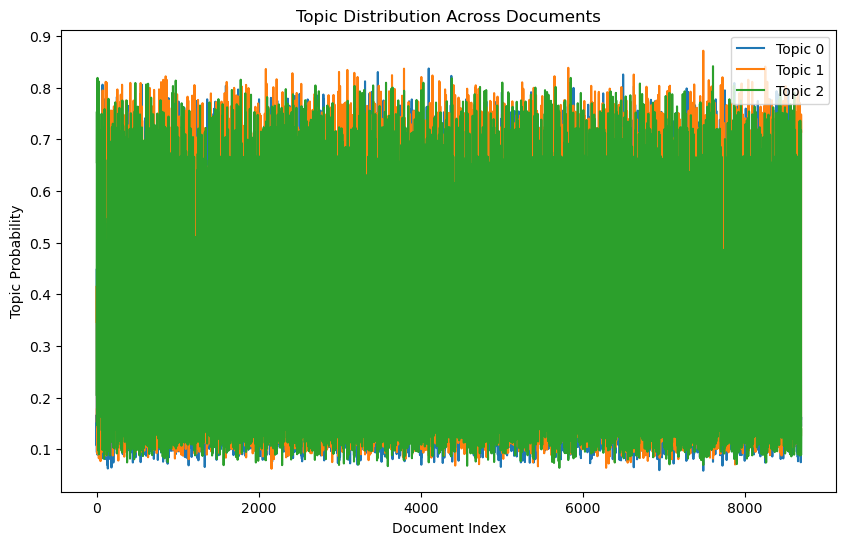

Topic 0: thanks, think, try, read, lol, eat, light, got, physic, chemistry
Topic 1: like, look, know, need, way, probably, water, help, really, work
Topic 2: wa, thank, good, make, ha, mean, thought, time, maybe, doe


In [31]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
train_data = pd.read_csv('dataset/train.csv')

# Preprocess text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

train_data['Processed_Comment'] = train_data['Comment'].apply(preprocess)

# TF-IDF Representation
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(train_data['Processed_Comment'])

# Manual Grid Search for LDA
best_score = float('inf')  # Initialize with a large value
best_model = None
best_params = None

param_grid = {
    'learning_decay': [0.5, 0.7, 0.9],
    'learning_offset': [10, 50, 100]
}

for learning_decay in param_grid['learning_decay']:
    for learning_offset in param_grid['learning_offset']:
        lda_model = LatentDirichletAllocation(
            n_components=3,  # 3 topics
            learning_decay=learning_decay,
            learning_offset=learning_offset,
            random_state=42
        )
        lda_model.fit(X_tfidf)
        perplexity = lda_model.perplexity(X_tfidf)
        print(f"learning_decay: {learning_decay}, learning_offset: {learning_offset}, Perplexity: {perplexity:.4f}")
        
        if perplexity < best_score:
            best_score = perplexity
            best_model = lda_model
            best_params = {'learning_decay': learning_decay, 'learning_offset': learning_offset}

# Best Parameters
print("Best Parameters:", best_params)
print(f"Best Perplexity: {best_score:.4f}")

# Transform data
X_lda = best_model.transform(X_tfidf)
cluster_assignments = np.argmax(X_lda, axis=1)
train_data['Cluster'] = cluster_assignments

# Silhouette Score
silhouette_avg = silhouette_score(X_tfidf, cluster_assignments, metric='cosine')
print(f"Silhouette Score (cosine distance): {silhouette_avg:.4f}")

# Save results
train_data.to_csv('lda_clustering_results.csv', index=False)

# Visualize topic distributions
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(X_lda[:, i], label=f"Topic {i}")
plt.title("Topic Distribution Across Documents")
plt.xlabel("Document Index")
plt.ylabel("Topic Probability")
plt.legend()
plt.show()

# Top Words
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(best_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


In [9]:
%pip install --user keras==2.12.0 tensorflow==2.12.0


                                              0.0/14.6 MB ? eta -:--:--
                                              0.1/14.6 MB 1.1 MB/s eta 0:00:14
     -                                        0.5/14.6 MB 5.0 MB/s eta 0:00:03
     ---                                      1.2/14.6 MB 8.5 MB/s eta 0:00:02
     ------                                   2.2/14.6 MB 11.9 MB/s eta 0:00:02
     ---------                                3.4/14.6 MB 14.3 MB/s eta 0:00:01
     ------------                             4.6/14.6 MB 16.4 MB/s eta 0:00:01
     ----------------                         5.9/14.6 MB 18.9 MB/s eta 0:00:01
     -------------------                      7.1/14.6 MB 19.0 MB/s eta 0:00:01
     -----------------------                  8.5/14.6 MB 20.1 MB/s eta 0:00:01
     ----------------------------            10.7/14.6 MB 27.3 MB/s eta 0:00:01
     ----------------------------------      13.1/14.6 MB 32.8 MB/s eta 0:00:01
     --------------------------------------  14.6/1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.0.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tables 3.8.0 requires blosc2~=2.0.0, but you have blosc2 3.0.0 which is incompatible.


In [12]:
%pip install --user tf-keras


  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl (7.5 kB)
  Using cached tensorflow_intel-2.18.0-cp311-cp311-win_amd64.whl (390.2 MB)
  Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Using cached keras-3.8.0-py3-none-any.whl (1.3 MB)
  Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-intel
    Found existing installation: tensorflow-intel 2.12.0
    Uninstalling tensorflow-intel-2.12.0:
      Successfully uninstalled tensorflow-intel-2.12.0
  Attemp

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 2.0.2 which is incompatible.
pytensor 2.26.4 requires numpy<2,>=1.17.0, but you have numpy 2.0.2 which is incompatible.
tables 3.8.0 requires blosc2~=2.0.0, but you have blosc2 3.0.0 which is incompatible.


In [13]:
%pip install --upgrade --user numpy==1.24.3 sentence-transformers pandas transformers


  Using cached numpy-1.24.3-cp311-cp311-win_amd64.whl (14.8 MB)
  Using cached sentence_transformers-3.4.0-py3-none-any.whl (275 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.0.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
pymc 5.20.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tables 3.8.0 requires blosc2~=2.0.0, but you have blosc2 3.0.0 which is incompatible.


In [18]:
%pip install --upgrade --user numpy<2

Note: you may need to restart the kernel to use updated packages.


The system cannot find the file specified.
